# __Quality Assesment Notebook for the auto-correlation of quasars in Mocks__

Conclusion:
    - What is the input evolution of bias QSO?
    - different nb of healpix pixels in data (1215) and randoms (1214)
    - data go down to z = 1.796 when randoms only to z = 1.8
    - get the way to send jobs on NERSC
    - run with more randoms
    - less redshift bins to compute the correlation
    - Get correct errors using https://github.com/igmhub/picca/pull/442

In [4]:
import fitsio
import scipy as sp
import scipy.constants
import glob
import healpy
import matplotlib.pyplot as plt
from matplotlib.pyplot import rcParams
import h5py
import os

import picca.constants
from picca import wedgize

%matplotlib inline
rcParams['figure.figsize'] = 10, 6
rcParams['lines.linewidth'] = 4
rcParams['axes.labelsize'] = 20
rcParams['legend.fontsize'] = 20
plt.rc('text',usetex=True)

In [60]:
nside = 16

In [61]:
### Get mocks
mock = {}
mock['team'] = 'saclay'
mock['mock_ver'] = 'v3.2'
mock['quick_ver'] = 'quick-0.2'
mock['mock_base'] = '/global/projecta/projectdirs/desi/mocks/lya_forest/'+mock['team']+'/'+mock['mock_ver']+'/'
mock['mock_quick'] = mock['mock_base']+'/'+mock['quick_ver']+'/'
mock['input_nz_QSO'] = '$HOME/Run_programs/igmhub/picca/CoLoRe_mocks/v4.0/Nz_qso_130618_2_colore1_hZs.txt'
mock['input_bias_QSO_evol'] = '$HOME/Run_programs/igmhub/picca/CoLoRe_mocks/v4.0/Bz_qso_G18.txt'

In [62]:
### Get mock products
mock['picca'] = '/project/projectdirs/desi/mocks/lya_forest/picca/'+mock['team']+'/'+mock['mock_ver']+'/'+mock['quick_ver']+'/'
mock['picca_Catalogs'] = mock['picca']+'/Catalogs/'
mock['picca_Correlations'] = mock['picca']+'/Correlations/'

## __Compare catalogs__

In [93]:
# Catalogs
cat_path = {'masterRSD':mock['mock_base']+'master.fits',
            'masternoRSD':mock['mock_base']+'master.fits',
            'desiDRQ':mock['mock_base']+mock['quick_ver']+'/zcat_desi_drq.fits',
            'random':mock['mock_base']+'/master_randoms.fits.gz',
            'data-red':mock['picca_Catalogs']+'/QSO_D_'+str(400000)+'.fits',
            'rand-red':mock['picca_Catalogs']+'/QSO_R_'+str(400000)+'.fits',
            }
redshift_key = {'masterRSD':'Z_QSO_RSD','masternoRSD':'Z_QSO_NO_RSD','desiDRQ':'Z','random':'Z','data-red':'Z','rand-red':'Z'}

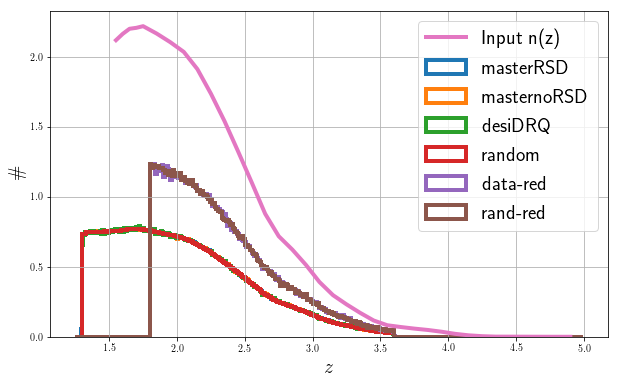

In [94]:
bins = sp.arange(1.25,5.,0.01)
for name,path in cat_path.items():
    h = fitsio.FITS(path)
    z = h[1][redshift_key[name]][:]
    h.close()
    plt.hist(z,bins=bins,histtype='step',label=name,density=True,linewidth=4)
inputNz = sp.loadtxt(os.path.expandvars(mock['input_nz_QSO']))
w = inputNz[:,0]>1.5
plt.plot(inputNz[:,0][w],inputNz[:,1][w]*0.01,linewidth=4,label='Input n(z)')

plt.xlabel(r'$z$')
plt.ylabel(r'$\mathrm{\#}$')
plt.legend()
plt.grid()

/global/homes/h/hdumasde/.conda/envs/picca_plots/lib/python3.6/site-packages/numpy/lib/function_base.py:838: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


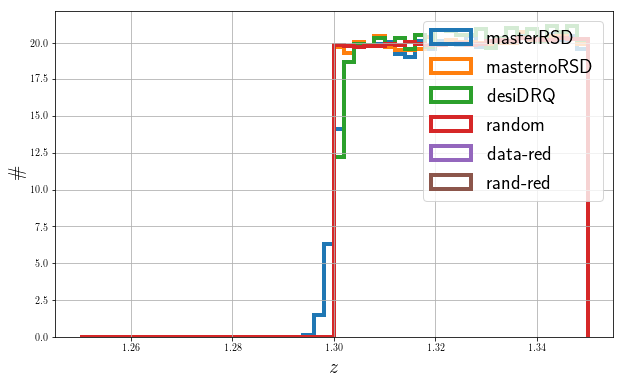

In [95]:
bins = sp.arange(1.25,1.35,0.002)
for name,path in cat_path.items():
    h = fitsio.FITS(path)
    z = h[1][redshift_key[name]][:]
    h.close()
    plt.hist(z,bins=bins,histtype='step',label=name,density=True,linewidth=4)
plt.xlabel(r'$z$')
plt.ylabel(r'$\mathrm{\#}$')
plt.legend()
plt.grid()

[]

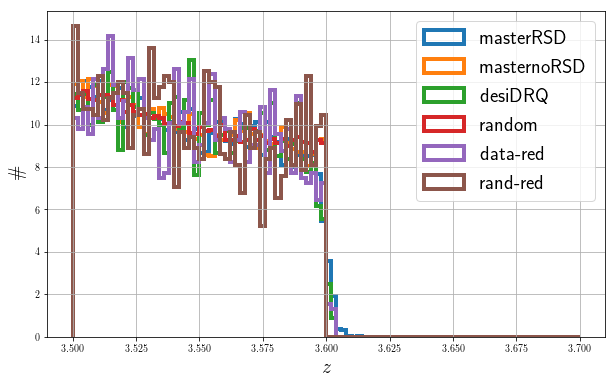

In [96]:
bins = sp.arange(3.5,3.7,0.002)
for name,path in cat_path.items():
    h = fitsio.FITS(path)
    z = h[1][redshift_key[name]][:]
    h.close()
    plt.hist(z,bins=bins,histtype='step',label=name,density=True,linewidth=4)
plt.xlabel(r'$z$')
plt.ylabel(r'$\mathrm{\#}$')
plt.legend()
plt.grid()
plt.plot()

## __Density of objects on the sky__

The following function allows to have a 2d histogram

In [97]:
def pix2ang_deg(nside,pix,nest=True):
    pix_rad_dec,pix_rad_ra = healpy.pix2ang(nside,pix,nest=nest)
    pix_ra = pix_rad_ra * 180 / sp.pi
    pix_dec = (sp.pi/2.-pix_rad_dec)*180./sp.pi
    return pix_ra, pix_dec

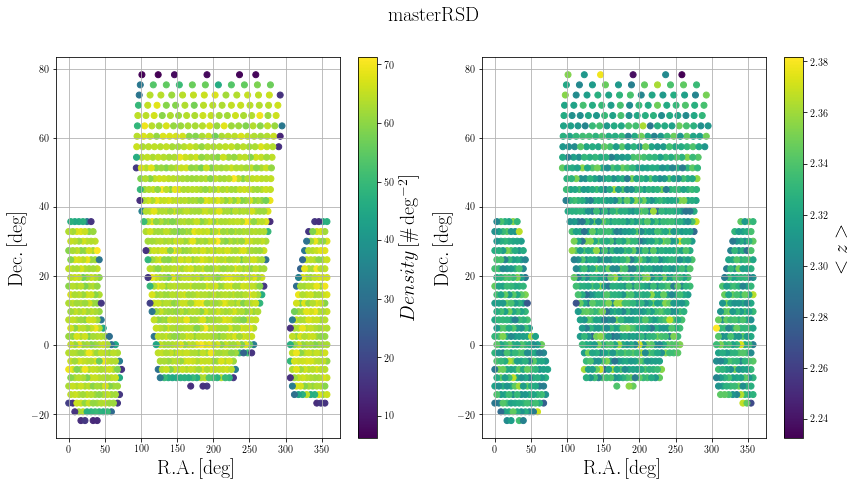

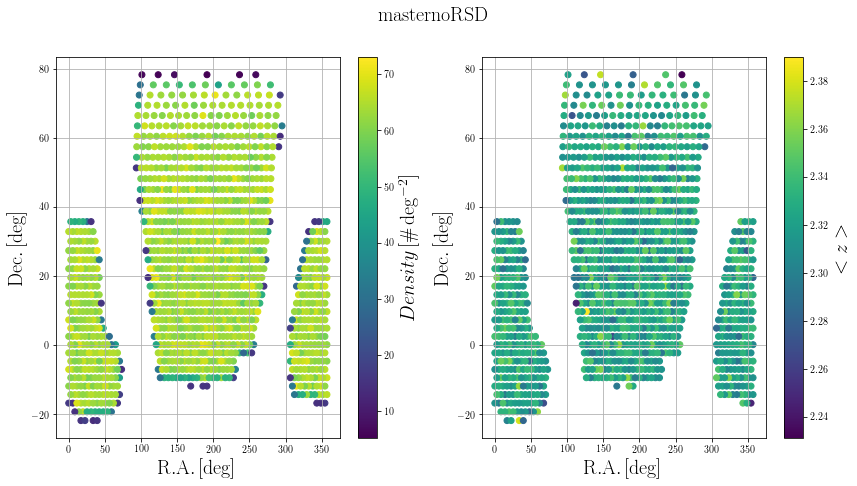

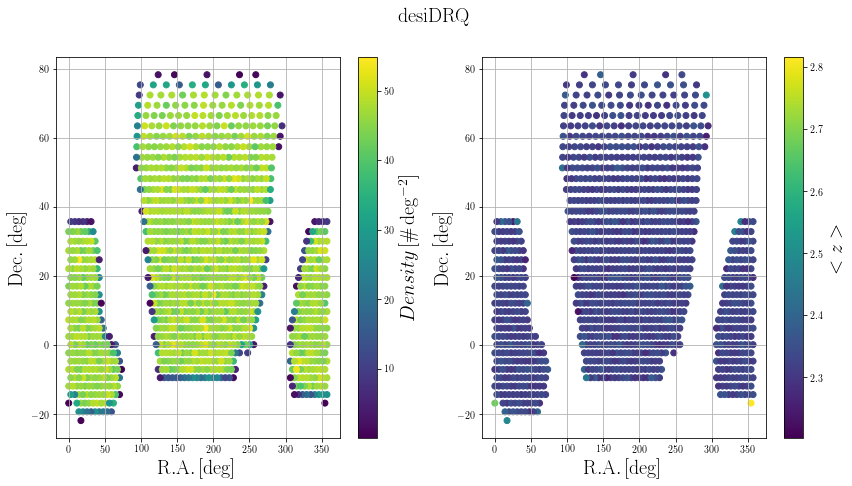

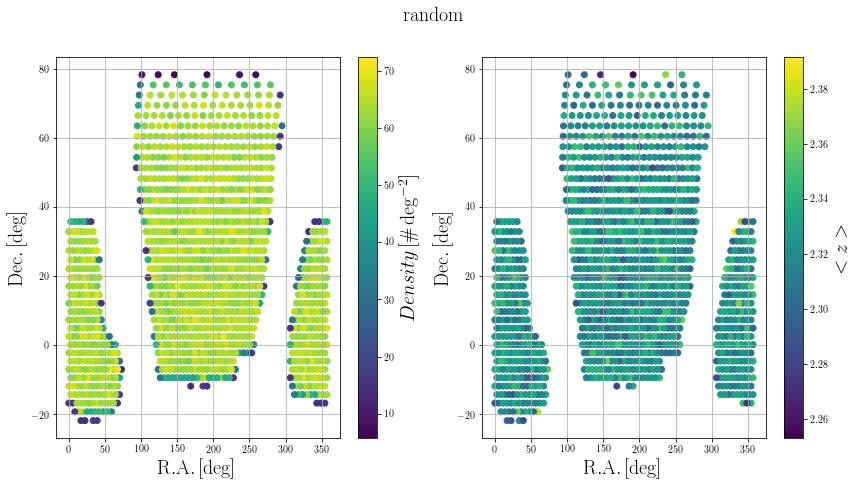

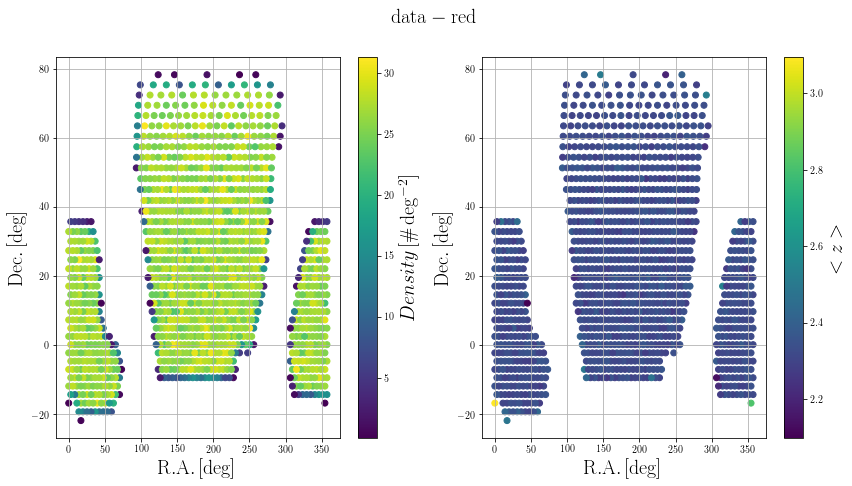

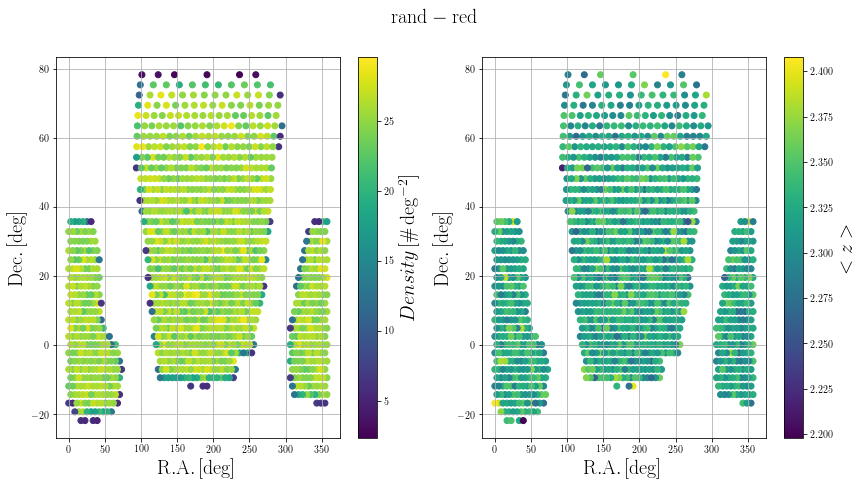

In [98]:
nside = 16
sp.random.seed(42)
nbQSO = 1000000
for name,path in cat_path.items():
    h = fitsio.FITS(path)
    ra = h[1]['RA'][:]
    dec = h[1]['DEC'][:]
    z = h[1][redshift_key[name]][:]

    w = z>1.8
    if 'Data' in name:
        w &= h[1]['MJD'][:]>55000
    ra = ra[w]
    dec = dec[w]
    z = z[w]

    h.close()
    
    w = sp.random.choice(sp.arange(ra.size,dtype=int),size=min(ra.size,nbQSO),replace=False)
    ra = ra[w]
    dec = dec[w]
    z = z[w]

    phi = ra*sp.pi/180.
    th = sp.pi/2.-dec*sp.pi/180.
    pix = healpy.ang2pix(nside,th,phi,nest=True)
    unique_pix = sp.unique(pix)
    ra_pix,dec_pix = pix2ang_deg(nside,unique_pix)
    
    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14,7))
    plt.suptitle(r'$\mathrm{'+name+'}$',fontsize=20)

    bincounts_pix = sp.bincount(pix)
    area_pix = healpy.pixelfunc.nside2pixarea(nside, degrees=True)
    density = bincounts_pix[unique_pix]/area_pix
    
    plot1 = ax1.scatter(ra_pix,dec_pix,c=density)
    cbar1 = plt.colorbar(plot1, ax=ax1)
    cbar1.set_label(r'$Density \, [\mathrm{\# \, deg^{-2}}]$',size=20)
    cbar1.update_ticks()
    ax1.set_xlabel(r'$\mathrm{R.A. \, [deg]}$')
    ax1.set_ylabel(r'$\mathrm{Dec. \, [deg]}$')
    ax1.grid()

    bincounts_pix = sp.bincount(pix)
    bincounts_z = sp.bincount(pix,weights=z)
    z_pix = bincounts_z[unique_pix]/bincounts_pix[unique_pix]

    plot2 = ax2.scatter(ra_pix,dec_pix,c=z_pix)
    cbar2 = plt.colorbar(plot2,ax=ax2)
    cbar2.set_label(r'$<z>$',size=20)
    cbar2.update_ticks()
    ax2.set_xlabel(r'$\mathrm{R.A. \, [deg]}$')
    ax2.set_ylabel(r'$\mathrm{Dec. \, [deg]}$')
    ax2.grid()

    plt.subplots_adjust(wspace=0.2)

## __Convert random catalogs to DRQ__

The first step we have to do is look at how many objects there are in the simulated data
and its simulated randoms.

We also need to look if the number of different healpix pixels is the same.

In [89]:
### Data
h = fitsio.FITS(mock['mock_base']+mock['quick_ver']+'/zcat_desi_drq.fits')
ra = h[1]['RA'][:]
dec = h[1]['DEC'][:]
z = h[1]['Z'][:]
phi = ra*sp.pi/180.
th = sp.pi/2.-dec*sp.pi/180.
pix = healpy.ang2pix(nside,th,phi)
print(' There are {} objects in the data catalog'.format(ra.size) )
print(' Across {} different healpix pixels of nside={}'.format(sp.unique(pix).size,nside) )
print(' with redshift in {} < z < {}'.format(z.min(), z.max()))
print('\n')
h.close()

### Randoms
h = fitsio.FITS(mock['mock_base']+'/master_randoms.fits.gz')
ra = h[1]['RA'][:]
dec = h[1]['DEC'][:]
z = h[1]['Z'][:]
phi = ra*sp.pi/180.
th = sp.pi/2.-dec*sp.pi/180.
pix = healpy.ang2pix(nside,th,phi)
print(' There are {} objects in the random catalog'.format(ra.size) )
print(' Across {} different healpix pixels of nside={}'.format(sp.unique(pix).size,nside) )
print(' with redshift in {} < z < {}'.format(z.min(), z.max()))
print('\n')
h.close()

 There are 1125315 objects in the data catalog
 Across 1212 different healpix pixels of nside=16
 with redshift in 1.300000548362732 < z < 3.603210687637329


 There are 39799397 objects in the random catalog
 Across 1228 different healpix pixels of nside=16
 with redshift in 1.3000000715255737 < z < 3.5999996662139893




In [47]:
nbData = 400000
nbRandoms = 1*nbData
zmin = 1.8

### Data
h = fitsio.FITS(mock['mock_base']+mock['quick_ver']+'/zcat_desi_drq.fits')
data = {}
for k in ['RA','DEC','Z']:
    data[k] = h[1][k][:]
for k in ['THING_ID','PLATE','MJD','FIBERID']:
    data[k] = sp.arange(1,data['Z'].size+1,dtype='int64')
w = data['Z']>zmin
for k in data.keys():
    data[k] = data[k][w]
h.close()
phi = data['RA']*sp.pi/180.
th = sp.pi/2.-data['DEC']*sp.pi/180.
pix = healpy.ang2pix(nside,th,phi)
data['PIX'] = pix

### Randoms
h = fitsio.FITS(mock['mock_base']+'/master_randoms.fits.gz')
rand = {}
for k in ['RA','DEC','Z']:
    rand[k] = h[1][k][:]
w = rand['Z']>zmin
for k in rand.keys():
    rand[k] = rand[k][w]
for k in ['THING_ID','PLATE','MJD','FIBERID']:
    rand[k] = data['THING_ID'].max()+1+sp.arange(rand['RA'].size)
h.close()
phi = rand['RA']*sp.pi/180.
th = sp.pi/2.-rand['DEC']*sp.pi/180.
pix = healpy.ang2pix(nside,th,phi)
rand['PIX'] = pix

### Same HEALpix
w = sp.in1d(data['PIX'],rand['PIX'])
print((~w).sum())
for k,v in data.items():
    v = v[w]
w = sp.in1d(rand['PIX'],data['PIX'])
print((~w).sum())
for k,v in rand.items():
    v = v[w]

### Save data
print(data['RA'].size)
assert nbData<=data['RA'].size
w = sp.random.choice(sp.arange(data['RA'].size), size=nbData, replace=False)
out = fitsio.FITS(mock['picca_Catalogs']+'/QSO_D_'+str(nbData)+'.fits','rw',clobber=True)
cols = [ v[w] for k,v in data.items() if k not in ['PIX'] ]
names = [ k for k in data.keys() if k not in ['PIX'] ]
out.write(cols,names=names)
out.close()
    
### Save randoms
print(rand['RA'].size)
assert nbRandoms<=rand['RA'].size
w = sp.random.choice(sp.arange(rand['RA'].size), size=nbRandoms, replace=False)
out = fitsio.FITS(mock['picca_Catalogs']+'/QSO_R_'+str(nbRandoms)+'.fits','rw',clobber=True)
cols = [ v[w] for k,v in rand.items() if k not in ['PIX'] ]
names = [ k for k in rand.keys() if k not in ['PIX'] ]
out.write(cols,names=names)
out.close()

0
81680
699868
24724303


## __Compute the auto-correlations of quasars__

Simply run the following command in your terminal

In [48]:
zint = ['0:10']
#zint = ['0:2.2','2.2:2.4','2.4:2.6','2.6:2.8','2.8:3.0','3.0:3.2','3.2:10']
#zint = ['0:2.2','2.2:2.6','2.6:3.0','3.0:3.4','3.4:10']

In [49]:
for zinterval in zint:
    zmin = zinterval.split(':')[0]
    zmax = zinterval.split(':')[1]

    if not os.path.isdir(mock['picca_Correlations']+'/co_z_{}_{}/'.format(zmin,zmax)):
        os.mkdir(mock['picca_Correlations']+'/co_z_{}_{}/'.format(zmin,zmax))

    cmd = ' srun --time 30 --qos debug do_co.py'
    cmd += ' --out '+mock['picca_Correlations']+'/co_z_{}_{}/co_DD_z_{}_{}.fits.gz'.format(zmin,zmax,zmin,zmax)
    cmd += ' --drq '+mock['picca_Catalogs']+'/QSO_D_'+str(nbData)+'.fits'
    cmd += ' --z-cut-min '+str(zmin)
    cmd += ' --z-cut-max '+str(zmax)
    cmd += ' --type-corr DD ;'
    print(cmd)
    print()

    cmd = ' srun --time 30 --qos debug  do_co.py'
    cmd += ' --out '+mock['picca_Correlations']+'/co_z_{}_{}/co_RR_z_{}_{}.fits.gz'.format(zmin,zmax,zmin,zmax)
    cmd += ' --drq '+mock['picca_Catalogs']+'/QSO_R_'+str(nbRandoms)+'.fits'
    cmd += ' --z-cut-min '+str(zmin)
    cmd += ' --z-cut-max '+str(zmax)
    cmd += ' --type-corr RR ;'
    print(cmd)
    print()

    cmd = ' srun --time 30 --qos debug  do_co.py'
    cmd += ' --out '+mock['picca_Correlations']+'/co_z_{}_{}/co_DR_z_{}_{}.fits.gz'.format(zmin,zmax,zmin,zmax)
    cmd += ' --drq '+mock['picca_Catalogs']+'/QSO_D_'+str(nbData)+'.fits'
    cmd += ' --drq2 '+mock['picca_Catalogs']+'/QSO_R_'+str(nbRandoms)+'.fits'
    cmd += ' --z-cut-min '+str(zmin)
    cmd += ' --z-cut-max '+str(zmax)
    cmd += ' --type-corr DR ;'
    print(cmd)
    print()

    cmd = ' srun --time 30 --qos debug  do_co.py'
    cmd += ' --out '+mock['picca_Correlations']+'/co_z_{}_{}/co_RD_z_{}_{}.fits.gz'.format(zmin,zmax,zmin,zmax)
    cmd += ' --drq '+mock['picca_Catalogs']+'/QSO_R_'+str(nbRandoms)+'.fits'
    cmd += ' --drq2 '+mock['picca_Catalogs']+'/QSO_D_'+str(nbData)+'.fits'
    cmd += ' --z-cut-min '+str(zmin)
    cmd += ' --z-cut-max '+str(zmax)
    cmd += ' --type-corr RD ;'
    print(cmd)
    print()

    cmd = 'srun --time 30 --qos debug export_co.py'
    cmd += ' --out '+mock['picca_Correlations']+'/co_z_{}_{}/co_z_{}_{}-exp.fits.gz'.format(zmin,zmax,zmin,zmax)
    cmd += ' --DD-file '+mock['picca_Correlations']+'/co_z_{}_{}/co_DD_z_{}_{}.fits.gz'.format(zmin,zmax,zmin,zmax)
    cmd += ' --RR-file '+mock['picca_Correlations']+'/co_z_{}_{}/co_RR_z_{}_{}.fits.gz'.format(zmin,zmax,zmin,zmax)
    cmd += ' --DR-file '+mock['picca_Correlations']+'/co_z_{}_{}/co_DR_z_{}_{}.fits.gz'.format(zmin,zmax,zmin,zmax)
    cmd += ' --RD-file '+mock['picca_Correlations']+'/co_z_{}_{}/co_RD_z_{}_{}.fits.gz'.format(zmin,zmax,zmin,zmax)
    print(cmd)
    print()

 srun --time 30 --qos debug do_co.py --out /project/projectdirs/desi/mocks/lya_forest/picca/saclay/v3.2/quick-0.2//Correlations//co_z_0_10/co_DD_z_0_10.fits.gz --drq /project/projectdirs/desi/mocks/lya_forest/picca/saclay/v3.2/quick-0.2//Catalogs//QSO_D_400000.fits --z-cut-min 0 --z-cut-max 10 --type-corr DD ;

 srun --time 30 --qos debug  do_co.py --out /project/projectdirs/desi/mocks/lya_forest/picca/saclay/v3.2/quick-0.2//Correlations//co_z_0_10/co_RR_z_0_10.fits.gz --drq /project/projectdirs/desi/mocks/lya_forest/picca/saclay/v3.2/quick-0.2//Catalogs//QSO_R_400000.fits --z-cut-min 0 --z-cut-max 10 --type-corr RR ;

 srun --time 30 --qos debug  do_co.py --out /project/projectdirs/desi/mocks/lya_forest/picca/saclay/v3.2/quick-0.2//Correlations//co_z_0_10/co_DR_z_0_10.fits.gz --drq /project/projectdirs/desi/mocks/lya_forest/picca/saclay/v3.2/quick-0.2//Catalogs//QSO_D_400000.fits --drq2 /project/projectdirs/desi/mocks/lya_forest/picca/saclay/v3.2/quick-0.2//Catalogs//QSO_R_400000.fits

## __Fit the 3D correlations__

In [64]:
for zinterval in zint:
    zmin = zinterval.split(':')[0]
    zmax = zinterval.split(':')[1]
    
    corr = mock['picca_Correlations']+'/co_z_{}_{}/co_DD_z_{}_{}.fits.gz'.format(zmin,zmax,zmin,zmax)
    correxp = mock['picca_Correlations']+'/co_z_{}_{}/co_z_{}_{}-exp.fits.gz'.format(zmin,zmax,zmin,zmax)
    fitdir = mock['picca_Correlations']+'Fit/QSO_QSO/co_z_{}_{}/'.format(zmin,zmax)

    ### Compute zeff
    if not os.path.isfile(corr):
        print('WARNING: not found ', corr)
        continue
    
    h = fitsio.FITS(corr)
    we = h['COR']['WE'][:]
    we = we.sum(axis=0)
    z = h['ATTRI']['Z'][:]
    rp = h['ATTRI']['RP'][:]
    rt = h['ATTRI']['RT'][:]
    r = sp.sqrt(rp**2. + rt**2.)
    w = (r>80.) & (r<120.)
    zeff = sp.sum( z[w]*we[w] )/sp.sum( we[w] )
    h.close()
    print(zeff)
    print(correxp)
    print(fitdir)
    print()

2.1856945361367592
/project/projectdirs/desi/mocks/lya_forest/picca/saclay/v3.2/quick-0.2//Correlations//co_z_0_10/co_z_0_10-exp.fits.gz
/project/projectdirs/desi/mocks/lya_forest/picca/saclay/v3.2/quick-0.2//Correlations/Fit/QSO_QSO/co_z_0_10/



## __Plot the 3D correlation__

In [65]:
toPlot = {}
for zinterval in zint:
    zmin = zinterval.split(':')[0]
    zmax = zinterval.split(':')[1]
    if not os.path.isfile(mock['picca_Correlations']+'/co_z_{}_{}/co_z_{}_{}-exp.fits.gz'.format(zmin,zmax,zmin,zmax)):
        continue
    toPlot['Mock-z-{}-{}'.format(zmin,zmax)] = { 'CORR':mock['picca_Correlations']+'/co_z_{}_{}/co_z_{}_{}-exp.fits.gz'.format(zmin,zmax,zmin,zmax),
                                            'FIT':mock['picca_Correlations']+'Fit/QSO_QSO/co_z_{}_{}/result.h5'.format(zmin,zmax),
                                            'NAME':'QSOxQSO',
                                            'TITLE':'z-{}-{}'.format(zmin,zmax)}

### __2d plot__

In [66]:
def convert1DTo2D(array1D,nbX,nbY):
    '''
        convert a 1D array to a 2D array
    '''

    array2D = sp.zeros(shape=(nbX,nbY))

    for k in range(array1D.size):
        i = k//nbY
        j = k%nbY

        array2D[i][j] = array1D[k]

    return array2D

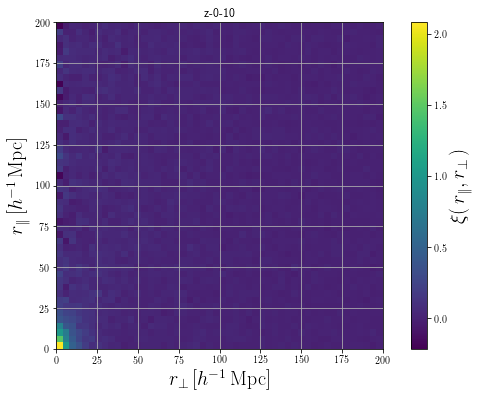

In [71]:
power = 0
for name,paths in sorted(toPlot.items()):
    h = fitsio.FITS(paths['CORR'])
    np = h[1].read_header()['NP']
    nt = h[1].read_header()['NT']
    rt_min = 0.
    rt_max = h[1].read_header()['RTMAX']
    rp_min = h[1].read_header()['RPMIN']
    rp_max = h[1].read_header()['RPMAX']
    r = sp.sqrt( h[1]['RP'][:]**2 + h[1]['RT'][:]**2 )
    da = h[1]['DA'][:]
    co = h[1]['CO'][:]
    extent = [rt_min, rt_max, rp_min, rp_max]
    r = convert1DTo2D(r,np,nt)
    da = convert1DTo2D(da,np,nt)
    er = convert1DTo2D(sp.diag(co),np,nt)
    da[er==0.] = float('nan')
    plt.imshow(da*r**power, origin='lower',extent=extent, interpolation='nearest')
    cbar = plt.colorbar()
    plt.title(paths['TITLE'])
    plt.xlabel(r'$r_{\perp} \, [h^{-1} \, \rm{Mpc}]$')
    plt.ylabel(r'$r_{\parallel} \, [h^{-1} \, \rm{Mpc}]$')
    cbar.set_label(r'$\xi(\, r_{\parallel},r_{\perp} \,)$')
    plt.grid(True)
    cbar.update_ticks()
    plt.show()

### __Wedge plots__

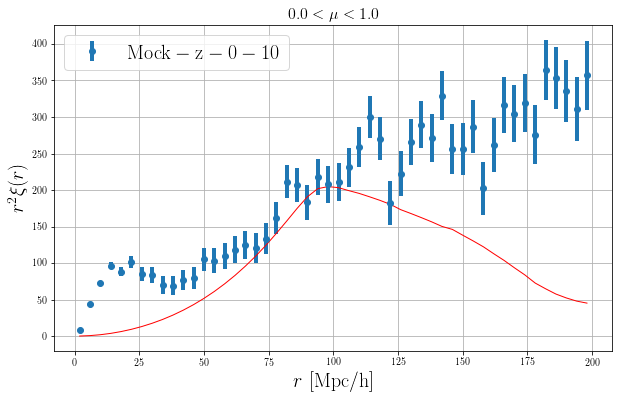

In [68]:
mus=[0.,1.]#, 0.5, 0.8, 0.95, 1.]
for mumin,mumax in zip(mus[:-1],mus[1:]):
    for name,paths in sorted(toPlot.items()):
        if not os.path.isfile(os.path.expandvars(paths['FIT'])): continue
        h = fitsio.FITS(paths['CORR'])
        ff = h5py.File(os.path.expandvars(paths['FIT']),'r')
        fit = ff[paths['NAME']+'/fit'][...]
        da = h[1]['DA'][:]
        co = h[1]['CO'][:]
        rpmin = h[1].read_header()['RPMIN']
        np = h[1].read_header()['NP']
        h.close()
        ff.close()
        b = wedgize.wedge(mumin=mumin,mumax=mumax,rpmin=rpmin,nrp=np,absoluteMu=True)
        r,d,c = b.wedge(da,co)
        r,f,_ = b.wedge(fit,co)
        plt.errorbar(r,d*r**2,yerr=sp.sqrt(c.diagonal())*r**2,fmt="o",label=r'$\mathrm{'+name+'}$')
        plt.plot(r,f*r**2,color='red',linewidth=1)
    plt.ylabel(r"$r^{2} \xi(r)$")
    plt.xlabel(r"$r~[\mathrm{Mpc/h}]$")
    plt.title(r"${}<\mu<{}$".format(mumin,mumax),fontsize=16)
    plt.legend()
    plt.grid()
    plt.show()

## __Slice plots__

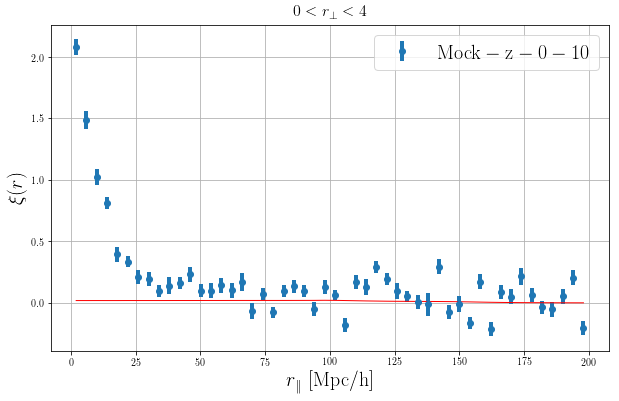

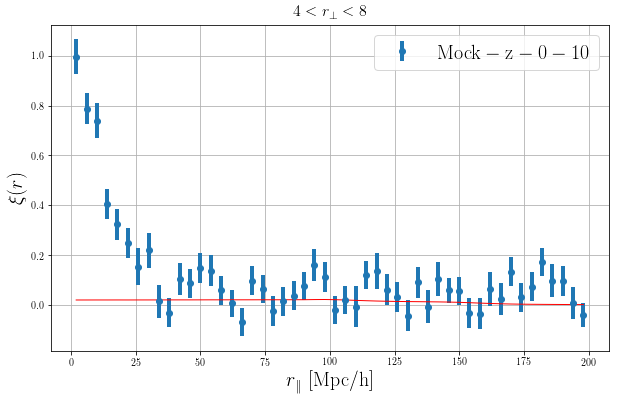

In [69]:
slices = [0, 1]
for s in slices:
    for name,paths in sorted(toPlot.items()):
        if not os.path.isfile(os.path.expandvars(paths['FIT'])): continue
        h = fitsio.FITS(paths['CORR'])
        ff = h5py.File(os.path.expandvars(paths['FIT']),'r')
        fit = ff[paths['NAME']+'/fit'][...]
        rp = h[1]['RP'][:]
        rt = h[1]['RT'][:]
        drt = h[1].read_header()['RTMAX'] / h[1].read_header()['NT']
        da = h[1]['DA'][:]
        er = sp.sqrt(sp.diag(h[1]['CO'][:]))
        h.close()
        ff.close()
        w = (rt>=s*drt) & (rt<(s+1)*drt)
        rp = rp[w]
        da = da[w]
        fit = fit[w]
        er = er[w]
        plt.errorbar(rp,da,yerr=er,fmt="o",label=r'$\mathrm{'+name+'}$')
        plt.plot(rp,fit,color='red',linewidth=1)
        ff.close()
    plt.ylabel(r"$\xi(r)$")
    plt.xlabel(r"$r_{\parallel}~[\mathrm{Mpc/h}]$")
    plt.title(r"${}<r_\perp<{}$".format(int(s*drt),int((s+1)*drt)),fontsize=16)
    plt.legend()
    plt.grid()
    plt.show()

## __Covariance matrix__

In [72]:
def getCorrelationMatrix(cov):
    '''
        Get the correlation matrix from a covaraince matrix
    '''

    ### Get normalisation factor
    invSqrtDiag = sp.zeros(sp.diag(cov).size)
    w = (sp.diag(cov)>0.)
    invSqrtDiag[w] = 1./sp.sqrt(sp.diag(cov)[w])

    ### Normalize
    cor = sp.array(cov)
    for i in range(cov[:,0].size):
        cor[:,i] *= invSqrtDiag[i]
        cor[i,:] *= invSqrtDiag[i]
        if invSqrtDiag[i]>0.: cor[i,i] = 1.

    return cor

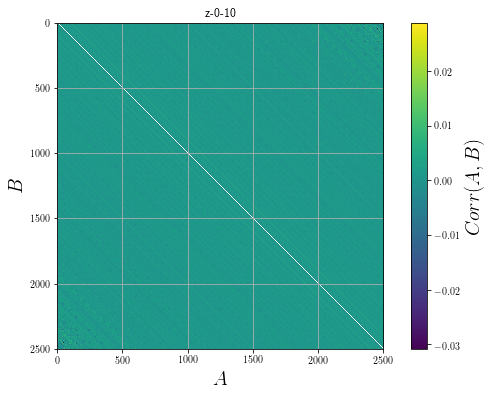

In [73]:
for name,paths in sorted(toPlot.items()):
    h = fitsio.FITS(paths['CORR'])
    co = h[1]['CO'][:]
    cor = getCorrelationMatrix(co)
    cor[cor==1.] = float('nan')
    cor[cor==0.] = float('nan')
    plt.imshow(cor, origin='upper', interpolation='nearest')
    cbar = plt.colorbar()
    plt.title(paths['TITLE'])
    plt.xlabel(r'$A$')
    plt.ylabel(r'$B$')
    cbar.set_label(r'$Corr(A,B)$')
    plt.grid(True)
    cbar.update_ticks()
    plt.show()

## __Compare fit results to data or theory__

In [74]:
zint = ['0:10']#,'0:2.2','2.2:2.4','2.4:2.6','2.6:2.8','2.8:3.0','3.0:3.2','3.2:10']

In [77]:
toPlot = {}
for zinterval in zint:
    zmin = zinterval.split(':')[0]
    zmax = zinterval.split(':')[1]
    if not os.path.isfile(mock['picca_Correlations']+'/co_z_{}_{}/co_z_{}_{}-exp.fits.gz'.format(zmin,zmax,zmin,zmax)):
        continue
    toPlot['Mockz{}{}'.format(zmin,zmax)] = { 'CORR':mock['picca_Correlations']+'/co_z_{}_{}/co_z_{}_{}-exp.fits.gz'.format(zmin,zmax,zmin,zmax),
                                            'FIT':mock['picca_Correlations']+'Fit/QSO_QSO/co_z_{}_{}/result.h5'.format(zmin,zmax),
                                            'NAME':'QSOxQSO',
                                            'TITLE':'z-{}-{}'.format(zmin,zmax)}

In [78]:
for name,paths in sorted(toPlot.items()):
    if not os.path.isfile(os.path.expandvars(paths['FIT'])): continue
    f = h5py.File(os.path.expandvars(paths['FIT']),'r')
    toPlot[name]['FIT_RES'] = {}
    toPlot[name]['FIT_RES']['ZEFF'] = f['best fit'].attrs['zeff']
    for k in list(f['best fit'].attrs['list of free pars']):
        toPlot[name]['FIT_RES'][k.decode("utf-8") ] = f['best fit'].attrs[k]
    for k in list(f['best fit'].attrs['list of fixed pars']):
        toPlot[name]['FIT_RES'][k.decode("utf-8") ] = f['best fit'].attrs[k]
    f.close()

In [79]:
def bias_vs_z_std(z, zref, alpha):
    r = ((1.+z)/(1+zref))**alpha
    return r
def growthRateStructure(z, omega_M_0):
    omega_m = omega_M_0*(1.+z)**3 / ( omega_M_0*(1.+z)**3+(1.-omega_M_0))
    f = sp.power(omega_m,0.55)
    return f

### The BAO parameters

[0.50001247]
[0.62184331]


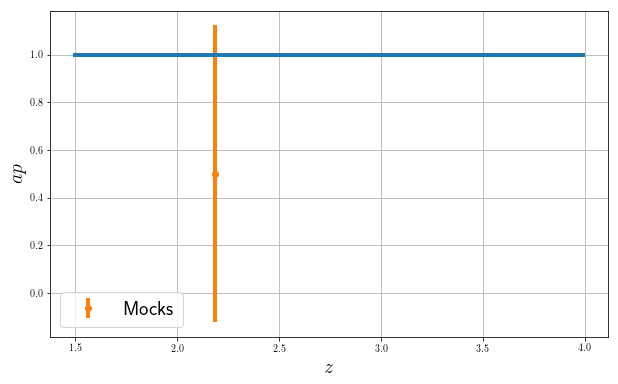

[0.50000003]
[0.02613471]


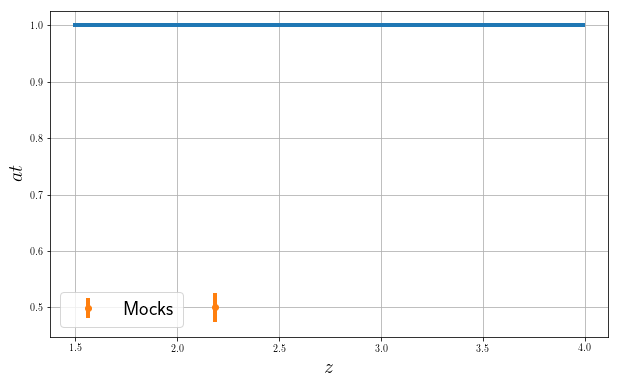

In [80]:
z = sp.arange(1.5,4.,0.01)
for p in ['ap','at']:
    plt.plot(z,sp.ones(z.size),linewidth=4)
    lst = [ el['FIT_RES'] for el in toPlot.values() if 'FIT_RES' in el.keys() ]
    xxx = sp.array([ el['ZEFF'] for el in lst ])
    yyy = sp.array([ el[p][0] for el in lst ])
    zzz = sp.array([ el[p][1] for el in lst ])
    print(yyy)
    print(zzz)
    plt.errorbar(xxx,yyy,zzz,fmt='o',label='Mocks')
    plt.xlabel(r'$z$')
    plt.ylabel(r'$'+p+'$')
    plt.legend()
    plt.grid()
    plt.show()

### The RSD parameter of the QSO

[0.12317405]
[0.00451008]


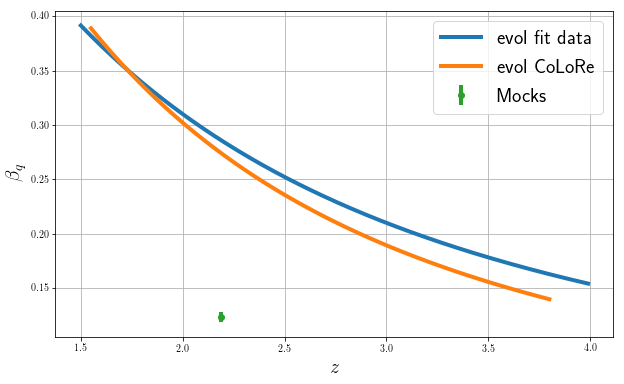

In [81]:
omega_M_0 = 0.315
z = sp.arange(1.5,4.,0.01)
f = growthRateStructure(z, omega_M_0)
bias = bias_vs_z_std(z, zref=0.37, alpha=1.44)
beta = f/bias
plt.plot(z,beta,linewidth=4,label='evol fit data')

biasCoLoRe = sp.loadtxt(os.path.expandvars(mock['input_bias_QSO_evol']))
betaCoLoRe = growthRateStructure(biasCoLoRe[:,0], omega_M_0)/biasCoLoRe[:,1]
w = biasCoLoRe[:,0]>1.5
plt.plot(biasCoLoRe[:,0][w],betaCoLoRe[w],linewidth=4,label='evol CoLoRe')

lst = [ el['FIT_RES'] for el in toPlot.values() if 'FIT_RES' in el.keys() ]
xxx = sp.array([ el['ZEFF'] for el in lst ])
yyy = sp.array([ el['beta_QSO'][0] for el in lst ])
zzz = sp.array([ el['beta_QSO'][1] for el in lst ])
plt.errorbar(xxx,yyy,zzz,fmt='o',label='Mocks')
print(yyy)
print(zzz)
plt.xlabel(r'$z$')
plt.ylabel(r'$\beta_{q}$')
plt.legend()
plt.grid()
plt.show()

### The growth of structure

[2.18569454]
[0.96]
[0.]


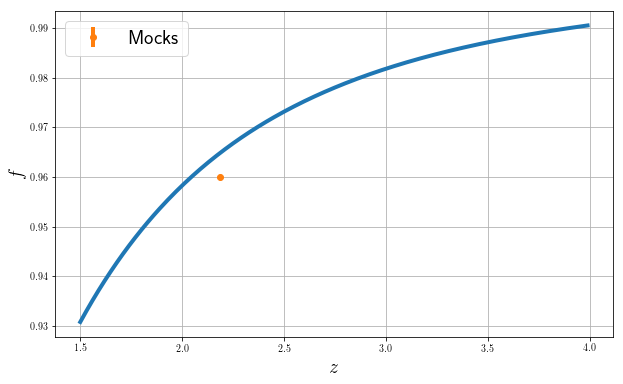

In [82]:
omega_M_0 = 0.315
z = sp.arange(1.5,4.,0.01)
f = growthRateStructure(z, omega_M_0)
plt.plot(z,f,linewidth=4)

lst = [ el['FIT_RES'] for el in toPlot.values() if 'FIT_RES' in el.keys() ]
xxx = sp.array([ el['ZEFF'] for el in lst ])
yyy = sp.array([ el['growth_rate'][0] for el in lst ])
zzz = sp.array([ el['growth_rate'][1] for el in lst ])
plt.errorbar(xxx,yyy,zzz,fmt='o',label='Mocks')
print(xxx)
print(yyy)
print(zzz)

plt.xlabel(r'$z$')
plt.ylabel(r'$f$')
plt.legend()
plt.grid()
plt.show()

### The bias of the QSO

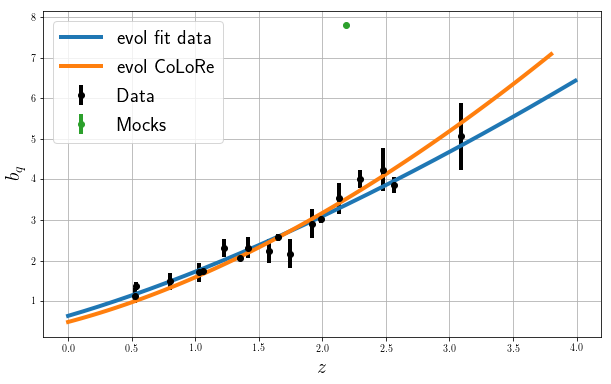

In [83]:
data = {}

### Croom (QSO, table 3) : https://arxiv.org/pdf/astro-ph/0409314v1.pdf
data['Croom2005'] = {'z':[0.526,0.804,1.026,1.225,1.413,1.579,1.745,1.921,2.131,2.475],
                     'b':[1.13,1.49,1.71,2.31,2.32,2.24,2.17,2.91,3.53,4.24],
                     'e':[0.18,0.21,0.24,0.23,0.27,0.30,0.35,0.35,0.38,0.53]}
### Shen (QSO, table 3) https://arxiv.org/pdf/1212.4526.pdf
data['Shen2013'] = {'z':[0.532], 'b':[1.38], 'e':[0.10]}
### Laurent et al. 2016 (QSO, table 2)  https://arxiv.org/pdf/1602.09010.pdf
data['Laurent2016'] = {'z':[2.30,2.56,3.09], 'b':[4.01,3.86,5.06], 'e':[0.22,0.19,0.83]}
### Laurent et al. 2017 (QSO, table 2) https://arxiv.org/pdf/1705.04718.pdf
data['Laurent2017'] = {'z':[1.06,1.35,1.65,1.99], 'b':[1.75,2.06,2.57,3.03], 'e':[0.08,0.08,0.09,0.11]}

label = True
for k,v in data.items():
    if label:
        plt.errorbar(v['z'],v['b'],yerr=v['e'],fmt='o',color='black',label='Data')
        label = False
    else:
        plt.errorbar(v['z'],v['b'],yerr=v['e'],fmt='o',color='black')

z = sp.arange(0.,4.,0.01)
bias = bias_vs_z_std(z, zref=0.37, alpha=1.44)
plt.plot(z,bias,linewidth=4,label='evol fit data')

biasCoLoRe = sp.loadtxt(os.path.expandvars(mock['input_bias_QSO_evol']))
plt.plot(biasCoLoRe[:,0],biasCoLoRe[:,1],linewidth=4,label='evol CoLoRe')

lst = [ el['FIT_RES'] for el in toPlot.values() if 'FIT_RES' in el.keys() ]
xxx = sp.array([ el['ZEFF'] for el in lst ])
yyy = sp.array([ el['bias_QSO'][0]*el['growth_rate'][0]/el['beta_QSO'][0] for el in lst ])
zzz = sp.array([ el['bias_QSO'][1] for el in lst ])
plt.errorbar(xxx,yyy,zzz,fmt='o',label='Mocks')

plt.xlabel(r'$z$')
plt.ylabel(r'$b_{q}$')
plt.legend()
plt.grid()
plt.show()